# **DEEP LEARNING PROJECT - PART 2**

# In this notebook, the first part is for LP estimations, the second part is for Deep Neural Networks

# Code for creating m-height 
### NOTE: I used the provided dataset for training, however the following code uses the LP to find m-height

In [ ]:
import torch
import itertools
import numpy as np
from scipy.optimize import linprog





def compute_m_height(G, m):
    k, n = G.shape
    print('n ',n)
    assert m <= n - k, "m must be at most n - k"
    
    # Ensure G is systematic
    I_k = np.eye(k)
    assert np.allclose(G[:, :k], I_k), "G must be systematic (first k columns should form an identity matrix)"
    
    indices = list(range(n)) #### [n> --> for any positive integer n
    Psi = list(itertools.product([-1, 1], repeat=m))  # Set of all binary vectors of length m
    
    best_height = -np.inf
    s = 0
    for a, b in itertools.permutations(indices, 2):#permutations(indices, 2):
        X_candidates = [set(comb) for comb in itertools.combinations(set(indices) - {a, b}, m - 1)] # combinations
        # print('a ',a)
        # print('b ', b)
        for X in X_candidates:
            Y = set(indices) - X - {a, b}
            # print('Y ', Y)
            # print('X ', X)
            for psi in Psi:
                tau = [a] + sorted(X) + [b] + sorted(Y)
                # print('tau ', tau)
                tau_inv = {xj: j for j, xj in enumerate(tau)}  # Calculate tau^{-1}
                # for i in range(k):
                #     print(psi[i])
                c = np.array([psi[0] * G[i, a] for i in range(k)])  # Update objective function

                A = []
                b_ineq = []

                for j in X:
                    # row = [(psi[list(X).index(j)] * G[i, tau_inv[j]] - psi[0] * G[i, a]) for i in range(k)]
                    row = [(psi[tau_inv[j]] * G[i, j] - psi[0] * G[i, a]) for i in range(k)]
                    # row = [( - psi[tau_inv[j]] * G[i, j] + psi[0] * G[i, a]) for i in range(k)]
                    A.append(row)
                    b_ineq.append(0)

                    # row_neg = [-psi[list(X).index(j)] * G[i, tau_inv[j]] for i in range(k)]
                    row_neg = [-psi[tau_inv[j]] * G[i, j] for i in range(k)]
                    # row_neg = [psi[tau_inv[j]] * G[i, j] for i in range(k)]
                    A.append(row_neg)
                    b_ineq.append(-1)
                    # b_ineq.append(1)

                for j in Y:
                    # A.append([G[i, tau_inv[j]] for i in range(k)])  # Correctly index using tau_inv
                    A.append([G[i, j] for i in range(k)])  # Correctly index using tau_inv
                    b_ineq.append(1)
                    # b_ineq.append(-1)

                    A.append([-G[i, j] for i in range(k)])
                    b_ineq.append(1)
                    # b_ineq.append(-1)

                A_eq = [[G[i, b] for i in range(k)]]
                b_eq = [1]
                # b_eq = [-1]

                res = linprog(-c, A_ub=A, b_ub=b_ineq, A_eq=A_eq, b_eq=b_eq, method='highs')

                s += 1

                if res.success:
                    best_height = max(best_height, -res.fun)
    # print(s)
    return best_height if best_height != -np.inf else None



In [ ]:
# # Example Usage:
G = np.array([[1, 0, 0.4759809, 0.993823, 0.819425], 
              [0, 1, -0.8960798 , -0.7442706, 0.3345122]])  # Systematic generator matrix

# G = np.array([[1, 0, 0.534, 0.583, -0.709, -0.053, 0.543, 0.927], 
#               [0, 1, 0.611 , -1.211, 0.233, -0.784, -0.659, -0.947]])  # Systematic generator matrix
m = 2
print("m-height:", compute_m_height(G, m))

n  5
m-height: 1.9242383477894285


# ***Code for DNNs***

## **NOTE:** the main difference between this code and the code for project 1, is that in this code, the model is a bit more complex (non-linear activation functions are added after conv layers); **more importantly**, in this notebook, for each setting (n,k,m), one separate model is being trained. However, the good thing about it is that the architecture for all model is the same, hence for each setting, it is only required to load model-states.

# Required packages for the model

In [1]:
import torch
import numpy as np
import joblib

from torch.utils.data import DataLoader, random_split, Dataset
import torch.nn as nn
import torch.nn.functional as F
from torch.distributions import Normal
import torch.optim as optim

from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

import math
from tqdm import tqdm
import time

# Class for creating the dataset for dataloader + function for preprocessing the data

In [2]:
class CustomDataset(Dataset):
    def __init__(self, data, targets):
        self.data = data
        self.targets = targets
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        return self.data[idx], self.targets[idx]

def pre_process_data(gen_mats, nfeat = 1): # matrix of shape [n_samples, n_dims]
    struct_mat = []
    m = nn.AdaptiveAvgPool1d(nfeat)
    for item in gen_mats:
        if type(item) == np.ndarray:
            item = torch.tensor(item.astype(float))
        # if type(item) == torch.Tensor:
        #     continue
        item = item.unsqueeze(0)
        struct_mat.append(m(item))
        
    return torch.cat((struct_mat))

An explanation for the model:
Generally, the model consists of 3 components: 
- An encoder 
- - encoder itself contains 2 calls to the simple encoder which maps modified matrices (17 features in this code) and the \[n,m,k\], each to a 10 dimensional feature vector (hence, after concatanation, the input to the first conv1d layer is 20 dimensional)
- - encoder also utilizes  3 conv1d layers with max pooling
- A Normalizing flow module (where I used planar flows for the trained model with 10 flows)
- A decoder: similar to the encoder, without the use of simple encoders 

### NOTE: the complete model is provided in VAEWithFlow class 

### NOTE: the model predicts log2($\cdot$)

In [3]:
class simple_encoder(nn.Module):
    def __init__(self, input_dim, output_dim):
        super().__init__()
        
        self.fc1 = nn.Linear(input_dim, 2)
        self.fc2 = nn.Linear(2, output_dim)
        self.relu = nn.ReLU()
    
    def forward(self, z):
        o = self.fc1(z)
        o = self.relu(o)
        o = self.fc2(o)
        return o
    


# Planar Flow
class PlanarFlow(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.w = nn.Parameter(torch.randn(1, dim))
        self.u = nn.Parameter(torch.randn(1, dim))
        self.b = nn.Parameter(torch.randn(1))
    
    def forward(self, z):
        linear = torch.matmul(z, self.w.T) + self.b
        activation = torch.tanh(linear)
        psi = (1 - activation ** 2) * self.w
        det_jacobian = torch.abs(1 + torch.matmul(psi, self.u.T))
        log_det = torch.log(det_jacobian + 1e-6)
        z_next = z + self.u * activation
        return z_next, log_det

# Radial Flow
class RadialFlow(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.z0 = nn.Parameter(torch.randn(1, dim))
        self.alpha = nn.Parameter(torch.randn(1))
        self.beta = nn.Parameter(torch.randn(1))
        self.dim = dim
    
    def forward(self, z):
        r = torch.norm(z - self.z0, dim=1, keepdim=True)
        h = 1 / (1 + r)
        beta_h = self.beta * h
        z_next = z + beta_h * (z - self.z0)
        log_det = (self.dim - 1) * torch.log(1 + beta_h) + torch.log(1 + beta_h + self.beta * h**2)
        return z_next, log_det

# Normalizing Flow Model
class NormalizingFlow(nn.Module):
    def __init__(self, dim, num_flows=2, flow_type='planar'):
        super().__init__()
        self.flows = nn.ModuleList([PlanarFlow(dim) if flow_type == 'planar' else RadialFlow(dim) for _ in range(num_flows)])
    
    def forward(self, z0):
        log_det_sum = 0
        z = z0
        for flow in self.flows:
            z, log_det = flow(z)
            log_det_sum += log_det
        return z, log_det_sum

# Encoder
class Encoder(nn.Module):
    def __init__(self, input_dim, latent_dim):
        super().__init__()
        
        self.emnk = simple_encoder(input_dim = 3, output_dim = 10)
        self.eg = simple_encoder(input_dim = input_dim - 3, output_dim = 10)
    
        self.conv1 = nn.Conv1d(in_channels = 1, out_channels = 16, kernel_size = 2, padding = 1)
        self.pool1 = nn.MaxPool1d(kernel_size = 2)
        self.conv2 = nn.Conv1d(in_channels = 16, out_channels = 64, kernel_size = 2, padding = 1) # was 32 previously - was 3 previously
        self.pool2 = nn.MaxPool1d(kernel_size = 2)
        self.conv3 = nn.Conv1d(in_channels = 64, out_channels = 256, kernel_size = 2, padding = 1) # was 128 previously
        self.pool3 = nn.MaxPool1d(kernel_size = 2)
        
        self.flatten = nn.Flatten()
        
        
        
#         self.fc1 = nn.Linear(input_dim, 64)
#         self.fc1 = nn.Linear(32*5, 64)
        self.fc1 = nn.Linear(256*3, 64) # 128 * 2 previously
        self.fc2 = nn.Linear(64, 64)
        self.mu = nn.Linear(64, latent_dim)
        self.log_var = nn.Linear(64, latent_dim)
        self.dropout = nn.Dropout(p=0.5)
        self.relu = nn.ReLU()
        
    def forward(self, x):
        
        f1 = self.emnk(x[:,-3:])
        f2 = self.eg(x[:,:-3])
        f = torch.cat([f1,f2], axis = 1)
        
        f = f.unsqueeze(1)
        
        h = self.conv1(f)
        h = self.relu(h)
        h = self.pool1(h)

        h = self.conv2(h)
        h = self.relu(h)
        h = self.pool2(h)

        h = self.conv3(h)
        h = self.relu(h)
        h = self.pool3(h)
        h = self.flatten(h)
#         print(h.shape)
        
        h = self.fc1(h)
        h = self.relu(h)
        h = self.dropout(h)
        h = self.fc2(h)
        h = self.relu(h)
        h = self.dropout(h)


        mu = self.mu(h)
        log_var = self.log_var(h)
        std = torch.exp(0.5 * log_var)
        eps = torch.randn_like(std)
        z0 = mu + eps * std
        return z0, mu, log_var

# Decoder
class Decoder(nn.Module):
    def __init__(self, latent_dim, output_dim):
        super().__init__()
        self.fc1 = nn.Linear(latent_dim, 64)
        self.fc2 = nn.Linear(64, 64)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.5)

        self.out = nn.Linear(64, output_dim)
    
    def forward(self, z):
        h = self.fc1(z)
        h = self.relu(h)
        h = self.dropout(h)
        h = self.fc2(h)
        h = self.relu(h)
        h = self.dropout(h) ### the following layer was not previously there....
        h = self.fc2(h)
        h = self.relu(h)
        h = self.dropout(h)

        o = self.out(h)
        return self.relu(o) # o if output is normalized, so it can be positive and # relu(o) output must be positive 

# Full VAE + Flow Model
class VAEWithFlow(nn.Module):
    def __init__(self, input_dim, latent_dim, output_dim, num_flows=2, flow_type='planar'):
        super().__init__()
        self.encoder = Encoder(input_dim, latent_dim)
        self.flow = NormalizingFlow(latent_dim, num_flows, flow_type)
        self.decoder = Decoder(latent_dim, output_dim)
        self.latent_dim = latent_dim
    
    def forward(self, x):
        z0, mu, log_var = self.encoder(x)
        z_k, log_det = self.flow(z0)
        x_recon = self.decoder(z_k)
        return x_recon, z_k, mu, log_var, log_det
    
    def sample(self, num_samples=1):
        z0 = torch.randn(num_samples, self.latent_dim)
        z_k, _ = self.flow(z0)
        return self.decoder(z_k)




# function for setting the random seeds (for reproduibility purposes)

In [4]:
def set_seed(seed=42):
    torch.manual_seed(seed)  # PyTorch CPU
    torch.cuda.manual_seed(seed)  # PyTorch GPU
    torch.cuda.manual_seed_all(seed)  # Multi-GPU
    np.random.seed(seed)  # NumPy
    # random.seed(seed)  # Python's random module
    torch.backends.cudnn.deterministic = True  # Ensures deterministic behavior
    torch.backends.cudnn.benchmark = False  # Slower, but more reproducible



### gathering all different settings in a list

In [5]:
nkm = []
for n in [9,10]:
    for k in [4,5,6]:
        for m in [2,3,4,5,6]:
            if n-k >= m:
                nkm.append([n,k,m])

nkm

[[9, 4, 2],
 [9, 4, 3],
 [9, 4, 4],
 [9, 4, 5],
 [9, 5, 2],
 [9, 5, 3],
 [9, 5, 4],
 [9, 6, 2],
 [9, 6, 3],
 [10, 4, 2],
 [10, 4, 3],
 [10, 4, 4],
 [10, 4, 5],
 [10, 4, 6],
 [10, 5, 2],
 [10, 5, 3],
 [10, 5, 4],
 [10, 5, 5],
 [10, 6, 2],
 [10, 6, 3],
 [10, 6, 4]]

# loading unmodified dataset 

In [ ]:
path = "D:\\TAMU\\courses\\spring 2025\\deep learning\\project\\New folder\\"
s_inds = np.load(path+'inds_small_dset.npy')
df = joblib.load(path + "results_dataframe.pkl")


# creating the modified datset 

In [ ]:
print('Getting targets, integers (n,k,m), and the modified matrices (all matrices will have the same number of features)')
target_vals = torch.tensor(df['result'].values)
nkm_vals = torch.tensor(df[['n','k','m']].values)
gmat_vals = pre_process_data(df['P'], nfeat=17)

print('Creating the modified features....')
modif_data = torch.cat([gmat_vals, nkm_vals], axis = 1)


# saving the modified dataset (to avoid loading the big dataset again)

In [ ]:
torch.save(modif_data, 'modif_data_all.pt')
torch.save(target_vals, 'target_vals_all.pt')

# Loading modified datasets

In [6]:
target_vals = torch.load('target_vals_all.pt')
modif_data = torch.load('modif_data_all.pt')

## In the following block, after fixing the random seeds, for each setting (n,k,m), I first create a train/validation/test dataset, and then train a specific model for that specific dataset. Train/Validation losses and the Best model for each specific setting are saved where the name of each file ends with nkm ....
## Also for encouraging a wider prediction rather than just the mean/mode, I devided the loss with the variance of training m-heights in each batch 

In [7]:
set_seed(42)

input_dim = 20#13
latent_dim = 2#4#5
output_dim = 1
num_flows = 10#10#4
num_epochs = 20
flow_type = 'planar'  # Choose 'planar' or 'radial'

device = 'cuda' if torch.cuda.is_available() else 'cpu'



for item in nkm:

    n,k,m = item[0], item[1], item[2]

    data, target = modif_data[[(modif_data[:,-1]==item[2]) & (modif_data[:,-2]==item[1]) & (modif_data[:,-3]==item[0])]], target_vals[[(modif_data[:,-1]==item[2]) & (modif_data[:,-2]==item[1]) & (modif_data[:,-3]==item[0])]]


    train_data, val_data, train_targets, val_targets = train_test_split(data, target, test_size=0.2, random_state=42)
    val_data, test_data, val_targets, test_targets = train_test_split(val_data, val_targets, test_size=0.5, random_state=42)

    inds = np.where(train_targets < 0.5*1e9) # removing very large values ---> can be outliers
    train_data, train_targets = train_data[inds], train_targets[inds]


    train_dataset = CustomDataset(torch.tensor(train_data), (torch.log2(torch.tensor(train_targets))))
    valid_dataset = CustomDataset(torch.tensor(val_data), torch.tensor(val_targets))
    test_dataset = CustomDataset(torch.tensor(test_data), torch.tensor(test_targets))




    batch_size = 1024 * 2 #256 * 4
    num_workers = 4
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)#, num_workers = num_workers)  # Shuffle only for training data
    valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False)#, num_workers = num_workers)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)#, num_workers = num_workers)








    model = VAEWithFlow(input_dim, latent_dim, output_dim, num_flows, flow_type).to(torch.float64).to(device)
    optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3)
    scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.9)

    



    bperf = torch.inf
    p_var = torch.tensor(0.2)
    model.train()
    eps = 1e-5
    scale_kl = 1e-3 
    var_scale = 1e-1 * 1* 0
    tr_loss_track, val_loss_track = [],[]
    tr_loss_all, val_loss_all, tr_kl_all, mse_all= [],[],[],[]
    for epoch in range(num_epochs):
        total_loss = 0
        t_start = time.time()
        
        step = 0
        for x,y in train_loader:
            optimizer.zero_grad()
            x,y = x.to(device), y.to(device) # ---> log2 y (in train loader we have log2 y)
            y_hat, z_k, mu, log_var, log_det = model(x) # ---> log2 y hat (model is forced to predict log2 y)


            d_var = torch.std(y)
            
            loss = torch.abs(( (y+eps)-(y_hat.squeeze(-1)+eps) )) ** 2  * (1/d_var) #2 
            loss = loss.mean()
            
            ### this mse is just for checking the model's performance --> it was not used in updating the model
            mse = F.mse_loss( y, y_hat.squeeze(-1))

            ### scaling the loss for putting more weight on the accuracy of the model 
            new_loss = 1 * loss 

            ### kl divergence loss for Normalizing Flow part which is optimized by elbo (similar loss as VAE)
            ### kl divergence is scaled which is a common practice, and helps the model to converge faster
            kl_div = ((mu-0)**2 + p_var**2)/(2*torch.exp(log_var)) + log_var - math.log(p_var) - 0.5
            elbo_loss = new_loss + scale_kl * kl_div.mean() - var_scale * torch.std(y_hat) #+ mse
            elbo_loss.backward()
                    

            optimizer.step()        
            total_loss += loss.item()

            ### keeping track of different losses
            tr_kl_all.append(kl_div.mean().item())
            tr_loss_all.append(loss.item())
            mse_all.append(mse.item())
            
            step += 1
            print(f'step {step}/{len(train_loader)}, loss: {loss.item()}, kl_div: {tr_kl_all[-1]}', end = '\r')

        tr_loss_track.append(total_loss/len(train_loader))
        # print(f'Epoch: {epoch}, Train error: {tr_loss_track[-1]}')

        ### Validating the model 
        model.eval()
        total_val_loss = 0
        with torch.no_grad():
            for x_val, y_val in valid_loader:
                x_val,y_val = x_val.to(device), y_val.to(device)
                y_hat, z_k, mu, log_var, log_det = model(x_val) # ---> log y hat

                # y_hat = torch.round(y_hat)
                
                # y_val = torch.log10(torch.log2(y_val)) # ---> since the model predicts the log2 y , and the validation y is not on log 
                y_val = torch.log2(y_val) # ---> since the model predicts the log2 y , and the validation y is not on log 
                
                ### again, for consistency, similar loss as in training is utilized 
                val_loss = F.mse_loss( (((y_val + eps))), ((y_hat.squeeze(-1) + eps)))
                total_val_loss += val_loss.item()
                val_loss_all.append(val_loss.item())
            
        
        total_val_loss /= len(valid_loader)
        scheduler.step()

        val_loss_track.append(total_val_loss)
        
        ### saving the loss track
        np.save(f'vaenf_kl_loss_all_check{n}{k}{m}.npy', np.array(tr_kl_all))
        np.save(f'vaenf_val_loss_track_check{n}{k}{m}.npy', np.array(val_loss_track))
        np.save(f'vaenf_tr_loss_track_check{n}{k}{m}.npy', np.array(tr_loss_track))
        
        if total_val_loss < bperf: 
            bperf = total_val_loss
            torch.save(model.state_dict(), f'vaenf_best_perf_model_check{n}{k}{m}.pth')
        e_time = time.time()
        if epoch%1 == 0:
                print(f"Setting (n,k,m):{n}, {k}, {m} ---  epoch {epoch+1}, train Loss: {total_loss / len(train_loader)}, valid loss: {total_val_loss}, lr: {scheduler.get_last_lr()}, time: {e_time-t_start}")






/tmp/job.13361568/ipykernel_2636778/2569856867.py:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_dataset = CustomDataset(torch.tensor(train_data), (torch.log2(torch.tensor(train_targets))))
/tmp/job.13361568/ipykernel_2636778/2569856867.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  valid_dataset = CustomDataset(torch.tensor(val_data), torch.tensor(val_targets))
/tmp/job.13361568/ipykernel_2636778/2569856867.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  test_dataset = CustomDataset(torch.tensor(test_data), torch.tens

Setting (n,k,m):9, 4, 2 ---  epoch 1, train Loss: 18.719646662715324, valid loss: 2.5364543489523457, lr: [0.0009000000000000001], time: 68.75858044624329
Setting (n,k,m):9, 4, 2 ---  epoch 2, train Loss: 0.5996204309991591, valid loss: 0.2028431071687419, lr: [0.0008100000000000001], time: 6.882423639297485
Setting (n,k,m):9, 4, 2 ---  epoch 3, train Loss: 0.45126248202162605, valid loss: 0.20207845545513478, lr: [0.000729], time: 6.869910955429077
Setting (n,k,m):9, 4, 2 ---  epoch 4, train Loss: 0.44998017806848806, valid loss: 0.20147227918771973, lr: [0.0006561000000000001], time: 6.800304174423218
Setting (n,k,m):9, 4, 2 ---  epoch 5, train Loss: 0.449062749444657, valid loss: 0.20150639069026247, lr: [0.00059049], time: 7.0766284465789795
Setting (n,k,m):9, 4, 2 ---  epoch 6, train Loss: 0.44905464544183493, valid loss: 0.20143644558563847, lr: [0.000531441], time: 6.786622762680054
Setting (n,k,m):9, 4, 2 ---  epoch 7, train Loss: 0.4490752980695866, valid loss: 0.2023252889378

Setting (n,k,m):9, 4, 4 ---  epoch 15, train Loss: 0.9487420315585885, valid loss: 0.8989998395589617, lr: [0.00020589113209464906], time: 6.7833147048950195
Setting (n,k,m):9, 4, 4 ---  epoch 16, train Loss: 0.9484833643062682, valid loss: 0.8992271156872876, lr: [0.00018530201888518417], time: 7.372478008270264
Setting (n,k,m):9, 4, 4 ---  epoch 17, train Loss: 0.9474618999043475, valid loss: 0.8970267978776165, lr: [0.00016677181699666576], time: 6.783093452453613
Setting (n,k,m):9, 4, 4 ---  epoch 18, train Loss: 0.9478167032542831, valid loss: 0.8988670656852773, lr: [0.0001500946352969992], time: 6.849815607070923
Setting (n,k,m):9, 4, 4 ---  epoch 19, train Loss: 0.9480059078294878, valid loss: 0.897510151770632, lr: [0.0001350851717672993], time: 6.709782600402832
Setting (n,k,m):9, 4, 4 ---  epoch 20, train Loss: 0.9472051207867543, valid loss: 0.8971743409705156, lr: [0.00012157665459056936], time: 6.8496949672698975
Setting (n,k,m):9, 4, 5 ---  epoch 1, train Loss: 25.427270

Setting (n,k,m):9, 5, 3 ---  epoch 9, train Loss: 0.9373422687153161, valid loss: 0.8616440345042481, lr: [0.000387420489], time: 9.066322088241577
Setting (n,k,m):9, 5, 3 ---  epoch 10, train Loss: 0.9378734189305854, valid loss: 0.8598340547105287, lr: [0.0003486784401], time: 9.1363525390625
Setting (n,k,m):9, 5, 3 ---  epoch 11, train Loss: 0.937087165624199, valid loss: 0.8597309825146718, lr: [0.00031381059609000004], time: 9.119112253189087
Setting (n,k,m):9, 5, 3 ---  epoch 12, train Loss: 0.9374898714864269, valid loss: 0.8599636672789193, lr: [0.00028242953648100003], time: 9.040767192840576
Setting (n,k,m):9, 5, 3 ---  epoch 13, train Loss: 0.9374315219368843, valid loss: 0.8601524015391515, lr: [0.00025418658283290005], time: 9.119585275650024
Setting (n,k,m):9, 5, 3 ---  epoch 14, train Loss: 0.9378074158745635, valid loss: 0.8647854376676829, lr: [0.00022876792454961005], time: 9.02848219871521
Setting (n,k,m):9, 5, 3 ---  epoch 15, train Loss: 0.9381811519198829, valid l

Setting (n,k,m):9, 6, 3 ---  epoch 3, train Loss: 1.8362256242597887, valid loss: 3.400487137093452, lr: [0.000729], time: 13.54459834098816
Setting (n,k,m):9, 6, 3 ---  epoch 4, train Loss: 1.836437040932658, valid loss: 3.397173987948732, lr: [0.0006561000000000001], time: 13.613371133804321
Setting (n,k,m):9, 6, 3 ---  epoch 5, train Loss: 1.8354586156198163, valid loss: 3.397801405380749, lr: [0.00059049], time: 13.637025833129883
Setting (n,k,m):9, 6, 3 ---  epoch 6, train Loss: 1.8352230777299874, valid loss: 3.396921905656162, lr: [0.000531441], time: 13.679264068603516
Setting (n,k,m):9, 6, 3 ---  epoch 7, train Loss: 1.8347116350933648, valid loss: 3.3976125333027456, lr: [0.0004782969], time: 13.625364065170288
Setting (n,k,m):9, 6, 3 ---  epoch 8, train Loss: 1.834783931564091, valid loss: 3.3973399987057227, lr: [0.00043046721], time: 13.658060312271118
Setting (n,k,m):9, 6, 3 ---  epoch 9, train Loss: 1.8339190528996114, valid loss: 3.397971962873368, lr: [0.000387420489],

Setting (n,k,m):10, 4, 3 ---  epoch 17, train Loss: 0.3314814250534427, valid loss: 0.10869671507012761, lr: [0.00016677181699666576], time: 5.495002031326294
Setting (n,k,m):10, 4, 3 ---  epoch 18, train Loss: 0.33151608583030834, valid loss: 0.10843170195309268, lr: [0.0001500946352969992], time: 5.424407720565796
Setting (n,k,m):10, 4, 3 ---  epoch 19, train Loss: 0.33147222701780304, valid loss: 0.1083570427030392, lr: [0.0001350851717672993], time: 5.483047246932983
Setting (n,k,m):10, 4, 3 ---  epoch 20, train Loss: 0.33168313331648785, valid loss: 0.10870477355615991, lr: [0.00012157665459056936], time: 5.479482889175415
Setting (n,k,m):10, 4, 4 ---  epoch 1, train Loss: 27.59632362692784, valid loss: 4.5411839488754175, lr: [0.0009000000000000001], time: 5.496189832687378
Setting (n,k,m):10, 4, 4 ---  epoch 2, train Loss: 0.8609289368678563, valid loss: 0.3069343047750729, lr: [0.0008100000000000001], time: 5.504251003265381
Setting (n,k,m):10, 4, 4 ---  epoch 3, train Loss: 0.

Setting (n,k,m):10, 4, 6 ---  epoch 10, train Loss: 1.8700067638965294, valid loss: 3.444008768829243, lr: [0.0003486784401], time: 5.4515581130981445
Setting (n,k,m):10, 4, 6 ---  epoch 11, train Loss: 1.8677389095249877, valid loss: 3.4434084529213336, lr: [0.00031381059609000004], time: 5.452825307846069
Setting (n,k,m):10, 4, 6 ---  epoch 12, train Loss: 1.866384431087307, valid loss: 3.4472991434451212, lr: [0.00028242953648100003], time: 5.6335129737854
Setting (n,k,m):10, 4, 6 ---  epoch 13, train Loss: 1.867294295148263, valid loss: 3.4410953444729344, lr: [0.00025418658283290005], time: 5.450088977813721
Setting (n,k,m):10, 4, 6 ---  epoch 14, train Loss: 1.8654351095108561, valid loss: 3.437525059317418, lr: [0.00022876792454961005], time: 5.416956663131714
Setting (n,k,m):10, 4, 6 ---  epoch 15, train Loss: 1.864985530014713, valid loss: 3.4408185788505734, lr: [0.00020589113209464906], time: 5.451409101486206
Setting (n,k,m):10, 4, 6 ---  epoch 16, train Loss: 1.86457157170

Setting (n,k,m):10, 5, 4 ---  epoch 3, train Loss: 0.9840414550945769, valid loss: 0.9539096254322862, lr: [0.000729], time: 6.738418102264404
Setting (n,k,m):10, 5, 4 ---  epoch 4, train Loss: 0.9812441222243041, valid loss: 0.9509662297467532, lr: [0.0006561000000000001], time: 6.744210958480835
Setting (n,k,m):10, 5, 4 ---  epoch 5, train Loss: 0.9774339919493267, valid loss: 0.9505230903736788, lr: [0.00059049], time: 6.746285438537598
Setting (n,k,m):10, 5, 4 ---  epoch 6, train Loss: 0.9755493091542964, valid loss: 0.950272213699977, lr: [0.000531441], time: 6.740067005157471
Setting (n,k,m):10, 5, 4 ---  epoch 7, train Loss: 0.9756719542607887, valid loss: 0.9502162190466271, lr: [0.0004782969], time: 6.820940017700195
Setting (n,k,m):10, 5, 4 ---  epoch 8, train Loss: 0.9755166321665684, valid loss: 0.9497913263566009, lr: [0.00043046721], time: 6.7411885261535645
Setting (n,k,m):10, 5, 4 ---  epoch 9, train Loss: 0.9752015230303261, valid loss: 0.9459417519097191, lr: [0.00038

Setting (n,k,m):10, 6, 2 ---  epoch 16, train Loss: 0.4972800166347594, valid loss: 0.2452689515286283, lr: [0.00018530201888518417], time: 9.063600778579712
Setting (n,k,m):10, 6, 2 ---  epoch 17, train Loss: 0.49681575770426734, valid loss: 0.24557549583392985, lr: [0.00016677181699666576], time: 9.002177715301514
Setting (n,k,m):10, 6, 2 ---  epoch 18, train Loss: 0.496807246109912, valid loss: 0.24522997984511477, lr: [0.0001500946352969992], time: 9.93465256690979
Setting (n,k,m):10, 6, 2 ---  epoch 19, train Loss: 0.496726127149524, valid loss: 0.2472207645181661, lr: [0.0001350851717672993], time: 9.01014256477356
Setting (n,k,m):10, 6, 2 ---  epoch 20, train Loss: 0.49690941438104985, valid loss: 0.24518422311191818, lr: [0.00012157665459056936], time: 9.096090078353882
Setting (n,k,m):10, 6, 3 ---  epoch 1, train Loss: 22.80030908161237, valid loss: 4.701518774465262, lr: [0.0009000000000000001], time: 9.156392812728882
Setting (n,k,m):10, 6, 3 ---  epoch 2, train Loss: 1.0435

# Loading and Plotting the performance on training/validation losses for each model

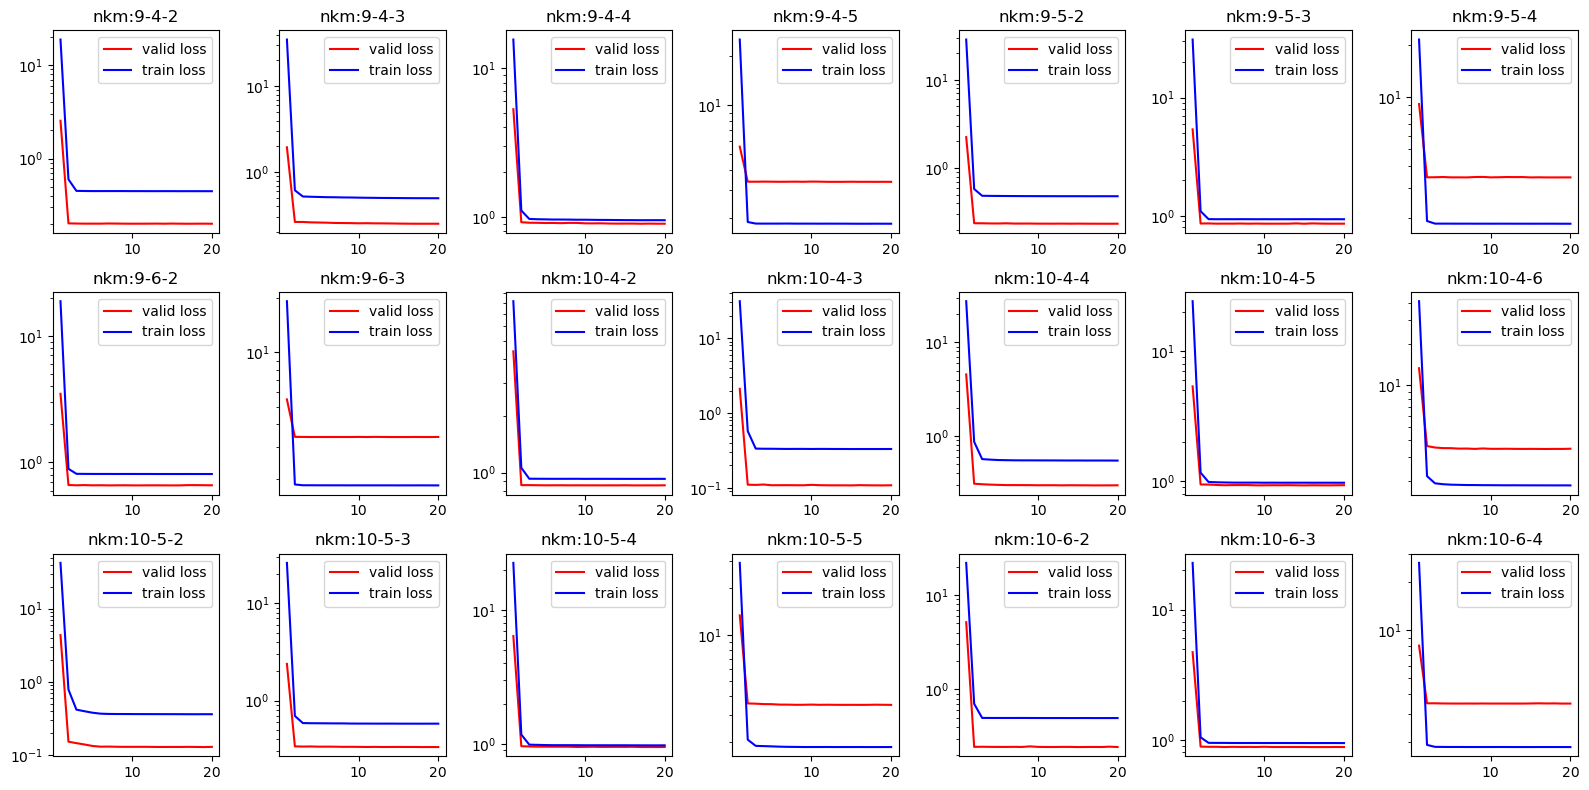

In [8]:
plt.figure(figsize=(16,8))
for i,item in enumerate(nkm):
    n,k,m = item[0], item[1], item[2]
    val_track = np.load(f'vaenf_val_loss_track_check{n}{k}{m}.npy')
    tr_track = np.load(f'vaenf_tr_loss_track_check{n}{k}{m}.npy')
    kl_track = np.load(f'vaenf_kl_loss_all_check{n}{k}{m}.npy')
    
    plt.subplot(3,7,i+1)
    

    plt.plot(range(1,len(val_track)+1),val_track, label = 'valid loss', color = 'red')
    plt.plot(range(1,len(tr_track)+1),tr_track[:], label = 'train loss', color = 'blue')
    plt.title(f'nkm:{n}-{k}-{m}')
    plt.yscale('log')
    plt.legend()

plt.tight_layout()

# loading and Testing each model on its specific dataset

In [10]:
all_test_losses = 0
for item in nkm:

    n,k,m = item[0], item[1], item[2]

    data, target = modif_data[[(modif_data[:,-1]==item[2]) & (modif_data[:,-2]==item[1]) & (modif_data[:,-3]==item[0])]], target_vals[[(modif_data[:,-1]==item[2]) & (modif_data[:,-2]==item[1]) & (modif_data[:,-3]==item[0])]]


    train_data, val_data, train_targets, val_targets = train_test_split(data, target, test_size=0.2, random_state=42)
    val_data, test_data, val_targets, test_targets = train_test_split(val_data, val_targets, test_size=0.5, random_state=42)

    
    inds = np.where(train_targets < 0.5*1e9) # removing very large values ---> can be outliers
    train_data, train_targets = train_data[inds], train_targets[inds]


    train_dataset = CustomDataset(torch.tensor(train_data), (torch.log2(torch.tensor(train_targets))))
    valid_dataset = CustomDataset(torch.tensor(val_data), torch.tensor(val_targets))
    test_dataset = CustomDataset(torch.tensor(test_data), torch.tensor(test_targets))







    batch_size = 1024 * 2 #256 * 4
    num_workers = 4
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)#, num_workers = num_workers)
    valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False)#, num_workers = num_workers)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)#, num_workers = num_workers)




    model = VAEWithFlow(input_dim, latent_dim, output_dim, num_flows, flow_type).to(torch.float64).to(device)

    checkpoint = torch.load(f'vaenf_best_perf_model_check{n}{k}{m}.pth', map_location=torch.device(device)) 
    model.load_state_dict(checkpoint)


    # model.eval()
    # total_val_loss = 0
    # with torch.no_grad():
    #     for x_val, y_val in valid_loader:
    #         x_val,y_val = x_val.to(device), y_val.to(device)
    #         y_hat, z_k, mu, log_var, log_det = model(x_val) # ---> log y hat

    #         # y_hat = torch.round(y_hat)
            
    #         # y_val = torch.log10(torch.log2(y_val)) # ---> since the model predicts the log2 y , and the validation y is not on log 
    #         y_val = torch.log2(y_val) # ---> since the model predicts the log2 y , and the validation y is not on log 
            
    #         ### again, for consistency, similar loss as in training is utilized 
    #         val_loss = F.mse_loss( (((y_val + eps))), ((y_hat.squeeze(-1) + eps)))
    #         total_val_loss += val_loss.item()
    #         val_loss_all.append(val_loss.item())
        
    
    # total_val_loss /= len(valid_loader)

    

    eps = 1e-5
    model.eval()
    total_test_loss = 0
    with torch.no_grad():
        for x_test, y_test in test_loader:
            x_test,y_test = x_test.to(device), y_test.to(device)
            y_hat, _,_,_,_ = model(x_test) # ---> log2 y
            
            test_loss = F.mse_loss( torch.log2((y_test + eps)), (y_hat.squeeze(-1)))
            
            total_test_loss += test_loss.item()

        total_test_loss /= len(test_loader)

    all_test_losses += total_test_loss/21
    print(f'test error for n={n}, k={k}, m={m}: {total_test_loss}')

print(f'\n <<<<<<<<<<<================================>>>>>>>>>>>> \n\nThe average test loss among all setting is: {all_test_losses}')

/tmp/job.13361568/ipykernel_2636778/1004143547.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_dataset = CustomDataset(torch.tensor(train_data), (torch.log2(torch.tensor(train_targets))))
/tmp/job.13361568/ipykernel_2636778/1004143547.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  valid_dataset = CustomDataset(torch.tensor(val_data), torch.tensor(val_targets))
/tmp/job.13361568/ipykernel_2636778/1004143547.py:19: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  test_dataset = CustomDataset(torch.tensor(test_data), torch.tens

test error for n=9, k=4, m=2: 0.19932754883655998
test error for n=9, k=4, m=3: 0.24676119959968337
test error for n=9, k=4, m=4: 0.8986820738364116
test error for n=9, k=4, m=5: 3.417671621535539
test error for n=9, k=5, m=2: 0.23090924926765424
test error for n=9, k=5, m=3: 0.8702714471171759
test error for n=9, k=5, m=4: 3.4507708111800004
test error for n=9, k=6, m=2: 0.6566033265730067
test error for n=9, k=6, m=3: 3.366630466432913
test error for n=10, k=4, m=2: 0.8557066415374316
test error for n=10, k=4, m=3: 0.10971846905345865
test error for n=10, k=4, m=4: 0.2997340497884563
test error for n=10, k=4, m=5: 0.9482708826481948
test error for n=10, k=4, m=6: 3.450919795943383
test error for n=10, k=5, m=2: 0.12621231093394947
test error for n=10, k=5, m=3: 0.33031343373292116
test error for n=10, k=5, m=4: 0.9407082123648588
test error for n=10, k=5, m=5: 3.3745548786918347
test error for n=10, k=6, m=2: 0.24826040971686508
test error for n=10, k=6, m=3: 0.8952494807502138
test 

# creating the function for the template 

In [ ]:
!pip install tamu_csce_636_project1

# Please use the following function for evaluating the model
### Important NOTE: in project one I mistakenly wrote that you create nmks instead of nkms; can you please kindly consider the correct order (nkm) when you are running the following function (I am taling about line 14 and the correct version, line 15)

In [ ]:
def ready_to_use_func(n,k,m,p_list, path = 'models/'): ## please save the model where ever you are using the function
    
    # checkpoint = torch.load(f'vaenf_best_perf_model_check{n}{k}{m}.pth', map_location=torch.device(device)) 

    
    #### loading the model 
    model_path = path + f'vaenf_best_perf_model_check{n}{k}{m}.pth'

    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    model = VAEWithFlow(input_dim=20, latent_dim=2, output_dim=1, num_flows=10, flow_type='planar').to(torch.float64).to(device)
    model_check_point = torch.load(model_path, map_location=torch.device(device))
    model.load_state_dict(model_check_point)    

    # nmks = torch.tensor([[n,m,k] for item in p_list])
    nkms = torch.tensor([[n,k,m] for item in p_list])

    p_list_tensor = torch.tensor(p_list) ### following the instrunctions in the template
    p_list_tensor = p_list_tensor.reshape(-1, p_list_tensor.shape[1] * p_list_tensor.shape[2])
    modif_matrices = pre_process_data(p_list_tensor, nfeat=17)
    
    modif_features = torch.cat([modif_matrices, nkms], axis = 1)
    modif_features = modif_features.to(device).to(torch.float64)

    output = model(modif_features)
    output = 2 ** output ### my model predicts the log2
    return output.flatten().tolist()
